In [27]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_training/')
from ensemble_train import *

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_explanation/')
from ensemble_explanation import *

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/model_evaluation/')
from ensemble_evaluation import compare_ensembles_rocs_on_dataset,calculate_rocs_on_datasets,calculate_metrics_on_datasets,calculate_experiment_performance_on_datasets
from base_evaluation import * 

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preprocessing')
from ensemble_preprocessing import execute_ensemble_preprocessing

os.chdir('/home/lucas/projects/mmml-alzheimer-diagnosis/src/data_preparation')
from ensemble_preparation import execute_ensemble_preparation

# Ensemble of CNNs + Demographics

## AD x CN

In [29]:
# mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_VGG19_BN_1125.csv'
# cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_MCI_COG_TESTS_1125.csv'

mri_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_VGG19_BN.csv'
cognitive_data_predictions_final_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/PREDICTIONS_AD_COG_TESTS.csv'

df_mri = prepare_mri_predictions(mri_data_path)
df_ensemble = prepare_ensemble_experiment_set(cognitive_data_predictions_final_path,mri_data_path)
df_ensemble.columns = ['SUBJECT', 'DATASET', 'AXIAL_23', 'CORONAL_43','SAGITTAL_26', 'COGTEST', 'DIAGNOSIS']

In [30]:
demographic_cols = ['AGE','MALE',
                    'YEARS_EDUCATION','HISPANIC',
                    'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'WIDOWED']
df_cog_final = pd.read_csv(cognitive_data_predictions_final_path).set_index("IMAGE_DATA_ID")
df_ensemble_demographics = df_cog_final[demographic_cols].merge(df_ensemble,right_index=True,left_index=True)

df_train,df_validation,df_test = get_experiment_sets(df_ensemble_demographics,cols_to_drop = ['SUBJECT','DATASET','COGTEST'])

datasets=[df_train,df_validation,df_test]
label = 'DIAGNOSIS'
ebm = ExplainableBoostingClassifier()
[ebm] = train_ensemble_models(df_train,label,[ebm])

patient_data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/COGNITIVE_DATA_PREPROCESSED.csv'
cutoff = get_optimal_threshold_for_model(ebm,df_validation,label)
df_patient_data = prepare_patient_data_for_explanations(patient_data_path,df_test,ebm,cutoff,
axial_label='AXIAL_23',coronal_label='CORONAL_43',sagittal_label='SAGITTAL_26')


/home/lucas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [31]:
from scipy.stats import mannwhitneyu

true_positives = df_patient_data.query("DIAGNOSIS == FINAL_PREDICTION and DIAGNOSIS == 'AD'")
true_negatives = df_patient_data.query("DIAGNOSIS == FINAL_PREDICTION and DIAGNOSIS == 'CN'")

false_positives = df_patient_data.query("DIAGNOSIS != FINAL_PREDICTION and DIAGNOSIS == 'CN'")
false_negatives = df_patient_data.query("DIAGNOSIS != FINAL_PREDICTION and DIAGNOSIS == 'AD'")

stats,pvalue = mannwhitneyu(true_positives['FINAL_PREDICTED_SCORE'],false_positives['FINAL_PREDICTED_SCORE'])
print("The predicted scores distribution is different between false positives and true positives because p-value = %.4f and  < 0.05" % pvalue)
print("false_positive mean(std) = %.4f (%.4g)" % (false_positives['FINAL_PREDICTED_SCORE'].mean(),false_positives['FINAL_PREDICTED_SCORE'].std()))
print("true_positive mean(std) = %.4f (%.4g)" % (true_positives['FINAL_PREDICTED_SCORE'].mean(),true_positives['FINAL_PREDICTED_SCORE'].std()))
print('------------------------------------')

stats,pvalue = mannwhitneyu(true_negatives['FINAL_PREDICTED_SCORE'],false_negatives['FINAL_PREDICTED_SCORE'])
print("The predicted scores distribution is not different between false negatives and true negatives because p-value = %.4f and > 0.05" % pvalue)
print("false_negative mean(std) = %.6f (%.6g)" % (false_negatives['FINAL_PREDICTED_SCORE'].mean(),false_negatives['FINAL_PREDICTED_SCORE'].std()))
print("true_negative mean(std) = %.6f (%.6g)" % (true_negatives['FINAL_PREDICTED_SCORE'].mean(),true_negatives['FINAL_PREDICTED_SCORE'].std()))

The predicted scores distribution is different between false positives and true positives because p-value = 0.0000 and  < 0.05
false_positive mean(std) = 0.0818 (0.2451)
true_positive mean(std) = 0.5485 (0.4679)
------------------------------------
The predicted scores distribution is not different between false negatives and true negatives because p-value = 0.0750 and > 0.05
false_negative mean(std) = 0.000001 (3.27109e-07)
true_negative mean(std) = 0.000001 (9.79869e-07)


In [32]:
explainer = EnsembleExplainer(model=ebm,ensemble_data=df_test,patients_data=df_patient_data)

In [33]:
true_positives.query("FINAL_PREDICTED_SCORE > 0.8").head()

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_23,CORONAL_43,SAGITTAL_26,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I250665,66.7,MALE,20,NO,WHITE,NO,0.999995,0.998159,0.997097,AD,0.975890,AD
I254813,77.7,FEMALE,19,NO,WHITE,NO,0.999836,0.998464,0.000272,AD,0.963038,AD
I280642,73.7,MALE,18,NO,WHITE,NO,0.999994,0.902817,0.141957,AD,0.985784,AD
I300256,66.8,MALE,12,NO,WHITE,NO,0.000002,0.830546,1.000000,AD,0.896259,AD
I306751,75.3,MALE,20,NO,WHITE,NO,0.997876,0.918308,0.999974,AD,0.999962,AD


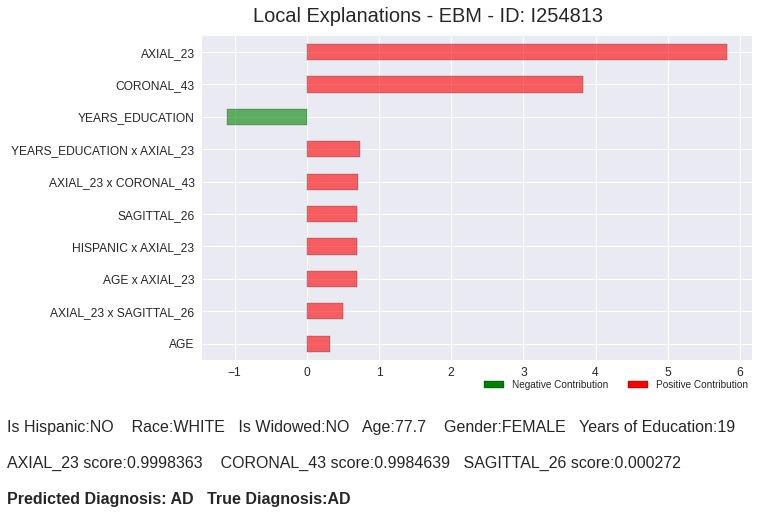

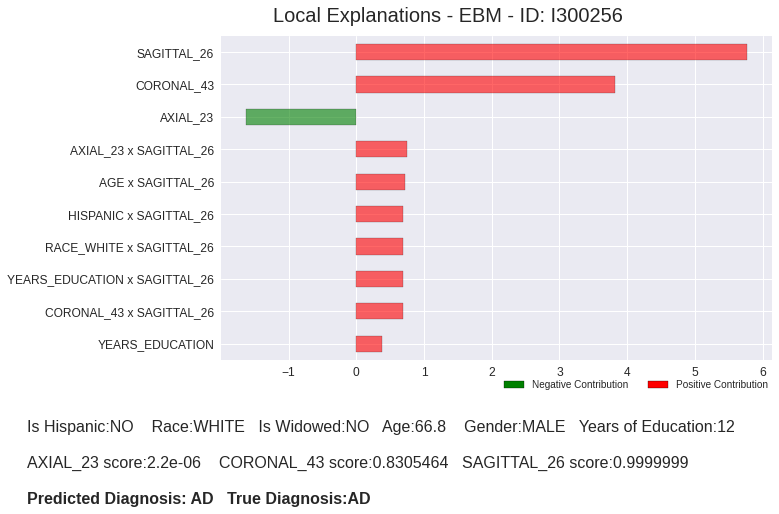

In [38]:
explanation_fig = explainer.explain(sample_id='I254813')
explanation_fig = explainer.explain(sample_id='I300256')

In [47]:
true_negatives.query("FINAL_PREDICTED_SCORE > 0.000001").head()
true_negatives.head()

,AGE,GENDER,YEARS_EDUCATION,HISPANIC,RACE,WIDOWED,AXIAL_23,CORONAL_43,SAGITTAL_26,DIAGNOSIS,FINAL_PREDICTED_SCORE,FINAL_PREDICTION
IMAGE_DATA_ID,,,,,,,,,,,,
I263730,71.4,FEMALE,18,NO,BLACK,NO,0.000003,0.000147,0.993213,CN,0.000002,CN
I267767,71.4,FEMALE,16,NO,WHITE,NO,0.009329,0.000282,0.007848,CN,0.000005,CN
I272687,70.2,FEMALE,14,NO,WHITE,NO,0.000036,0.233709,0.015388,CN,0.000002,CN
I278142,73.5,MALE,16,NO,WHITE,YES,0.000018,0.000019,0.010521,CN,0.000002,CN
I278309,84.4,MALE,18,NO,WHITE,NO,0.000000,0.000000,0.002297,CN,0.000003,CN


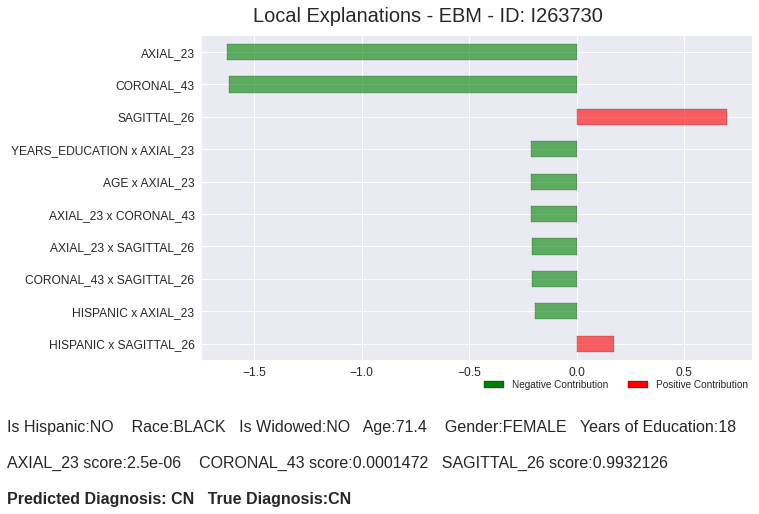

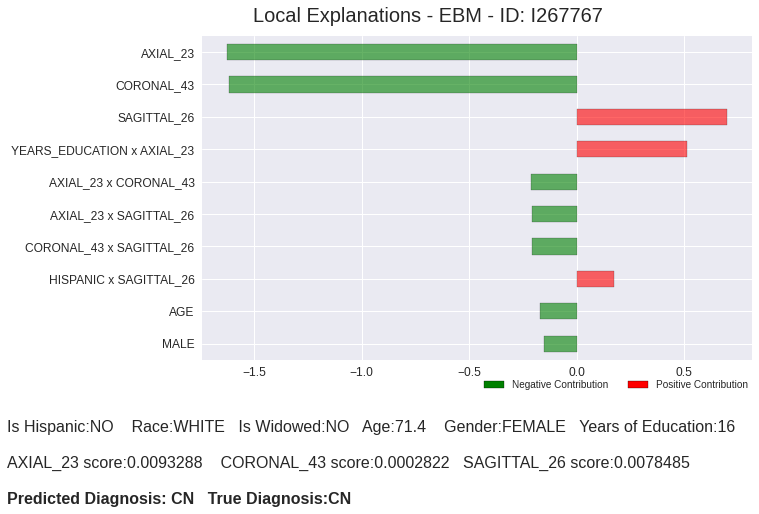

In [51]:
explanation_fig = explainer.explain(sample_id='I263730')
explanation_fig = explainer.explain(sample_id='I267767')

In [ ]:
explanation_fig = explainer.explain(sample_id='I263730')
explanation_fig = explainer.explain(sample_id='I267767')